# Предсказание заработной платы на основе личных данных 
В этом проекте мы обучим модели, чтобы предсказать, зарабатывает ли конкретный человек менее 50 000 долларов США или более 50 000 долларов США в год. Эти данные были получены из [базы данных переписи населения США]("https://www.kaggle.com/rdcmdev/adult-income-dataset") и состоят из таких характеристик, как профессия, возраст, страна происхождения, образование и сфера работы. В этом практическом проекте мы выполним следующие задания:
* Импорт наборов данных и библиотек
* Проводим разведочный анализ данных
* Выполняем визуализацию данных
* Подготовка данных
* Строим и оцениваем простую логистическую регрессионную модель
* Строим и оцениваем модель XGBoost
* Сравниваем модели между собой

### Импорт наборов данных и библиотек

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
sns.set_palette("pastel")

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report,accuracy_score,roc_curve,confusion_matrix
import xgboost

import optuna

encode = LabelEncoder()

In [2]:
# В csv файле нет название столбцов, поэтому мы создаем заранее подготовленный список имен 
columns = ['Возраст', 'Класс работы', 'Итоговый взнос', 'Образование', 'Лет образования','Семейное положение', 'Род деятельности', 'Текущий статус', 'Раса', 'Пол', 'Прирост капитала', 'Капитальный убыток', 'Часов в неделю', 'Страна происхождения', 'Доход']

# Читаем csv файл и в качестве аргумента передаем имена столбцов
df = pd.read_csv("data.csv", names = columns)
df.head()

,Возраст,Класс работы,Итоговый взнос,Образование,Лет образования,Семейное положение,Род деятельности,Текущий статус,Раса,Пол,Прирост капитала,Капитальный убыток,Часов в неделю,Страна происхождения,Доход
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Проводим разведочный анализ данных

In [3]:
# Получение информации о наборе данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Возраст               32561 non-null  int64 
 1   Класс работы          32561 non-null  object
 2   Итоговый взнос        32561 non-null  int64 
 3   Образование           32561 non-null  object
 4   Лет образования       32561 non-null  int64 
 5   Семейное положение    32561 non-null  object
 6   Род деятельности      32561 non-null  object
 7   Текущий статус        32561 non-null  object
 8   Раса                  32561 non-null  object
 9   Пол                   32561 non-null  object
 10  Прирост капитала      32561 non-null  int64 
 11  Капитальный убыток    32561 non-null  int64 
 12  Часов в неделю        32561 non-null  int64 
 13  Страна происхождения  32561 non-null  object
 14  Доход                 32561 non-null  object
dtypes: int64(6), object(9)
memory usage:

In [4]:
# Получение статистической сводки по набору данных
df.describe()

,Возраст,Итоговый взнос,Лет образования,Прирост капитала,Капитальный убыток,Часов в неделю
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
# Получаем количество уникальных значений в "Класс работы"
df["Класс работы"].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Класс работы, dtype: int64

In [6]:
# Заменяем значение '?' на mode()[0]
# Метод mode()[0] возвращает значение, которое встречается чаще всего.
df["Класс работы"].replace(" ?", df["Класс работы"].mode()[0], inplace=True)
df["Класс работы"].value_counts()

 Private             24532
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Класс работы, dtype: int64

In [7]:
# Получаем количество уникальных значений в "Род деятельности"
df['Род деятельности'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Род деятельности, dtype: int64

In [8]:
# Заменяем значение '?' на mode()[0]
# Метод mode()[0] возвращает значение, которое встречается чаще всего.
df['Род деятельности'].replace(' ?', df['Род деятельности'].mode()[0], inplace = True)
df["Род деятельности"].value_counts()


 Prof-specialty       5983
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Род деятельности, dtype: int64

In [9]:
# Получаем количество уникальных значений в "Страна происхождения"
df['Страна происхождения'].value_counts()

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [10]:
# Заменяем '?' на 'other'
df['Страна происхождения'].replace(' ?',' other', inplace = True)
df['Страна происхождения'].value_counts()


 United-States                 29170
 Mexico                          643
 other                           583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

### Выполняем визуализацию данных

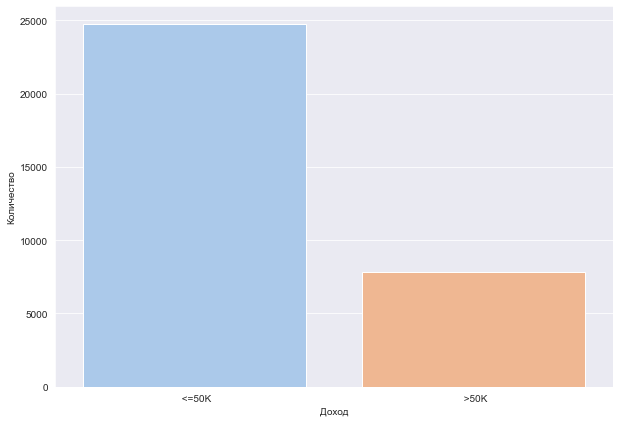

In [11]:
# Визуализируем информацию о доходах
plt.figure(figsize=(10,7))
ax = sns.countplot(df["Доход"])
ax.set_ylabel("Количество")
plt.show('png')

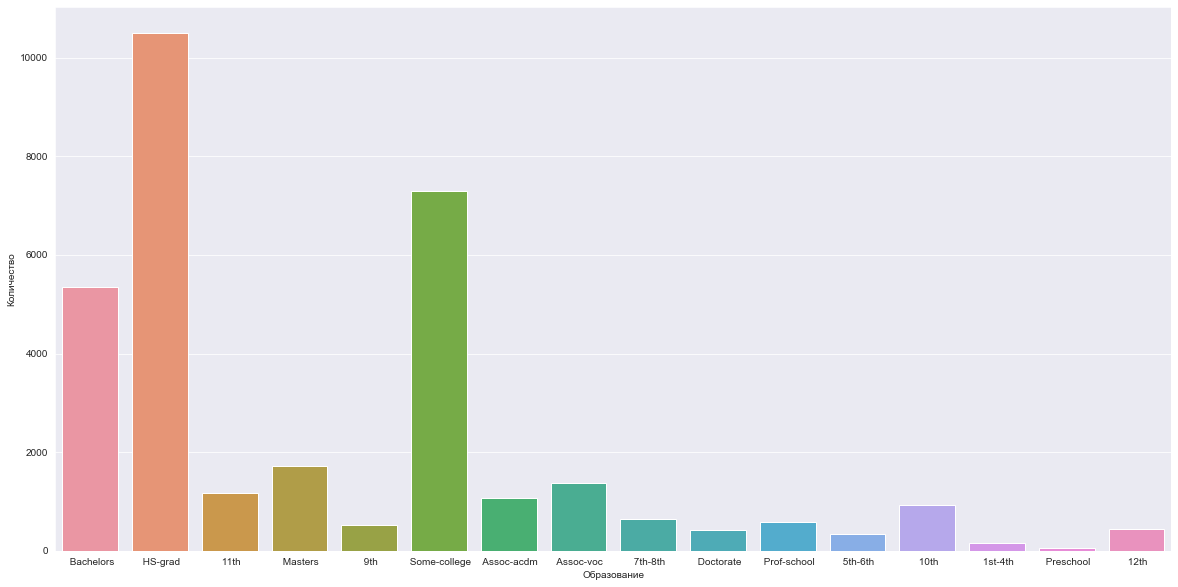

In [12]:
# Визуализируем информацию об образовании
plt.figure(figsize = (20, 10))
ax = sns.countplot(df['Образование'])
ax.set_ylabel("Количество")
plt.show('png')

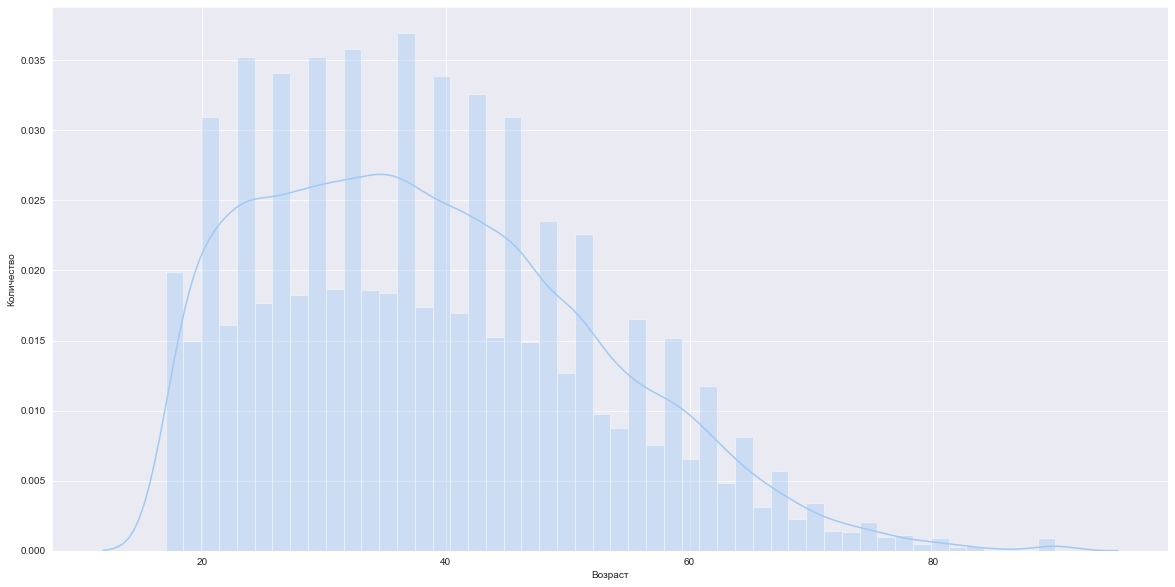

In [13]:
# Визуализируем информацию о возрасте
plt.figure(figsize = (20,10))
ax = sns.distplot(df["Возраст"])
ax.set_ylabel("Количество")
plt.show('png')

<Figure size 1440x1440 with 0 Axes>

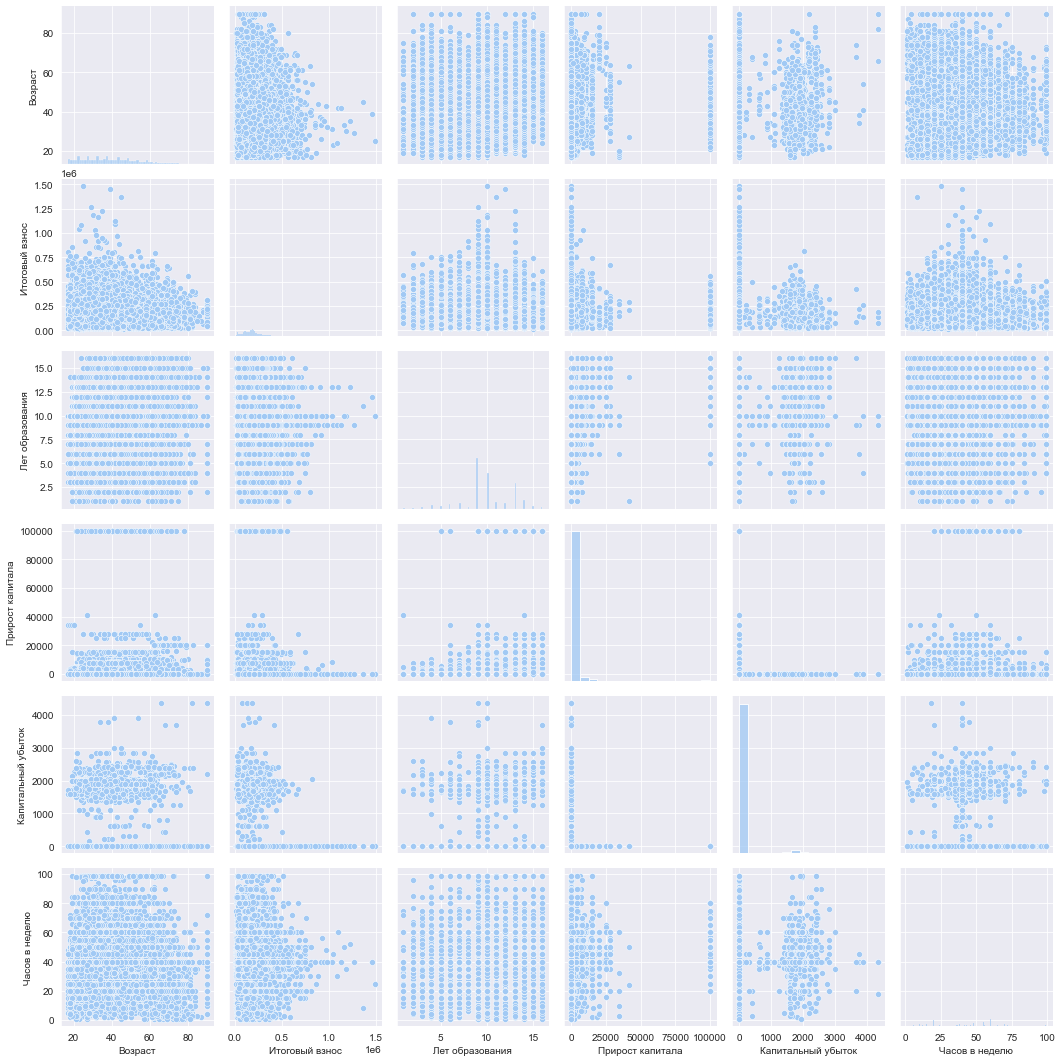

In [14]:
# Визуализируем отношения между всеми парами переменных
plt.figure(figsize = (20, 20))
ax = sns.pairplot(df)
plt.show('png')

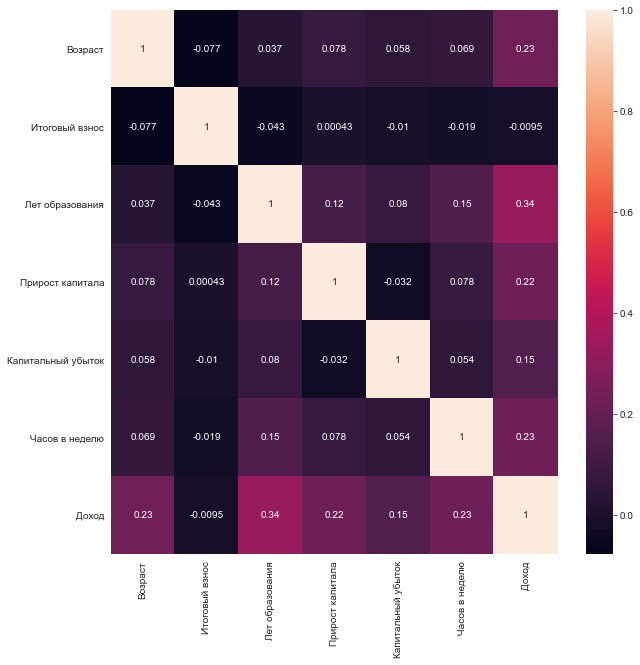

In [15]:
# Построим матрицу корреляции
df["Доход"] = encode.fit_transform(df["Доход"])

plt.figure(figsize = (10, 10))
ax = sns.heatmap(df.corr(), annot=True)
plt.show('png')

### Подготовка данных

In [16]:
# Кодируем категориальные данные
for i in df.columns:
    df[i] = encode.fit_transform(df[i])

df.head()

,Возраст,Класс работы,Итоговый взнос,Образование,Лет образования,Семейное положение,Род деятельности,Текущий статус,Раса,Пол,Прирост капитала,Капитальный убыток,Часов в неделю,Страна происхождения,Доход
0,22,6,2671,9,12,4,0,1,4,1,25,0,39,38,0
1,33,5,2926,9,12,2,3,0,4,1,0,0,12,38,0
2,21,3,14086,11,8,0,5,1,4,1,0,0,39,38,0
3,36,3,15336,1,6,2,5,0,2,1,0,0,39,38,0
4,11,3,19355,9,12,2,9,5,2,0,0,0,39,4,0


In [17]:
X = df.drop(columns = ["Доход"])
X

,Возраст,Класс работы,Итоговый взнос,Образование,Лет образования,Семейное положение,Род деятельности,Текущий статус,Раса,Пол,Прирост капитала,Капитальный убыток,Часов в неделю,Страна происхождения
0,22,6,2671,9,12,4,0,1,4,1,25,0,39,38
1,33,5,2926,9,12,2,3,0,4,1,0,0,12,38
2,21,3,14086,11,8,0,5,1,4,1,0,0,39,38
3,36,3,15336,1,6,2,5,0,2,1,0,0,39,38
4,11,3,19355,9,12,2,9,5,2,0,0,0,39,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,10,3,16528,7,11,2,12,5,4,0,0,0,37,38
32557,23,3,8080,11,8,2,6,0,4,1,0,0,39,38
32558,41,3,7883,11,8,6,0,4,4,0,0,0,39,38
32559,5,3,12881,11,8,4,0,3,4,1,0,0,19,38


In [18]:
y = df["Доход"]
y

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: Доход, Length: 32561, dtype: int64

In [19]:
# Выполняем одномоментное кодирование
features = ['Класс работы','Образование','Семейное положение','Род деятельности','Текущий статус','Раса','Пол','Страна происхождения']

X = pd.get_dummies(X, columns = features)
X.head()

,Возраст,Итоговый взнос,Лет образования,Прирост капитала,Капитальный убыток,Часов в неделю,Класс работы_0,Класс работы_1,Класс работы_2,Класс работы_3,...,Страна происхождения_32,Страна происхождения_33,Страна происхождения_34,Страна происхождения_35,Страна происхождения_36,Страна происхождения_37,Страна происхождения_38,Страна происхождения_39,Страна происхождения_40,Страна происхождения_41
0,22,2671,12,25,0,39,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,33,2926,12,0,0,12,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,21,14086,8,0,0,39,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,36,15336,6,0,0,39,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,11,19355,12,0,0,39,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# масштабируем данные перед обучением модели
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

In [21]:
# Разбиваем данные на тестовые и обучающие наборы

X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.2)

### Строим и оцениваем простую логистическую регрессионную модель

In [22]:
def objective_lr(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    tol = trial.suggest_float("tol", 0.0001, 10, log=True)
    C = trial.suggest_float("C", 0.0001, 10.0, log=True)
    intercept = trial.suggest_categorical("fit_intercept", [True, False])
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

    ## Создание модели
    classifier = LogisticRegression(penalty=penalty,
                                    tol=tol,
                                    C=C,
                                    fit_intercept=intercept,
                                    solver=solver,
                                    multi_class="auto",
                                   )
    ## Обучаем модель
    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

In [23]:
# Промодим оптимизацию гиперпараметров
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")
study_lr.optimize(objective_lr, n_trials=50)

[I 2022-02-06 18:09:38,792] A new study created in memory with name: LogisticRegression
[I 2022-02-06 18:09:38,884] Trial 0 finished with value: 0.7314601566098572 and parameters: {'penalty': 'l2', 'tol': 0.29106401403469234, 'C': 0.00011821573842357785, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 0 with value: 0.7314601566098572.
[I 2022-02-06 18:09:43,258] Trial 1 finished with value: 0.8515277138031629 and parameters: {'penalty': 'l1', 'tol': 0.00017307899321415189, 'C': 0.6282423237819159, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 1 with value: 0.8515277138031629.
[I 2022-02-06 18:09:43,501] Trial 2 finished with value: 0.8519883310302472 and parameters: {'penalty': 'l2', 'tol': 0.001479219864960123, 'C': 0.00100082332666836, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 2 with value: 0.8519883310302472.
[I 2022-02-06 18:09:43,546] Trial 3 finished with value: 0.7692307692307693 and parameters: {'penalty': 'l2', 'tol': 7.6114418567019

In [24]:
print("Лучшие параметры : {}".format(study_lr.best_params))
print("Наилучшая точность : {}".format(study_lr.best_value))

Лучшие параметры : {'penalty': 'l1', 'tol': 0.000685392323314406, 'C': 0.11998795141156035, 'fit_intercept': True, 'solver': 'liblinear'}
Наилучшая точность : 0.8527560264087211


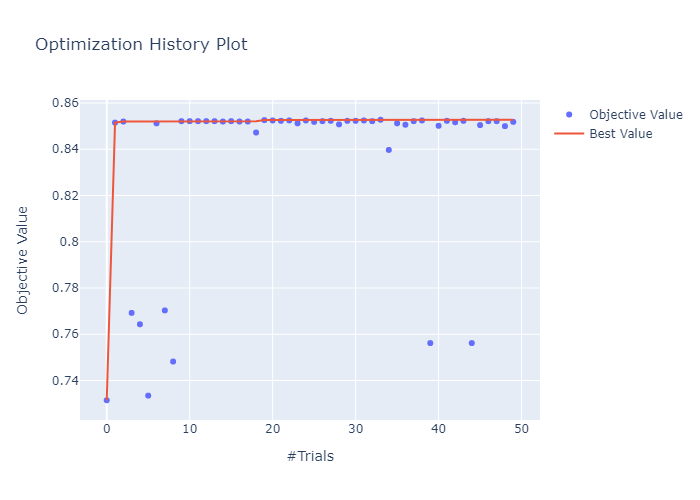

In [25]:
fig = optuna.visualization.plot_optimization_history(study_lr)
fig.show("png")

In [26]:
lr = LogisticRegression(**study_lr.best_params, multi_class="auto")
lr.fit(X_train, y_train)
predicted_lr = lr.predict(X_test)

In [27]:
accuracy_lr = accuracy_score(y_test, predicted_lr)

# Метрики качества модели
print(classification_report(y_test, predicted_lr))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4925
           1       0.74      0.60      0.67      1588

    accuracy                           0.85      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.85      0.85      6513



Text(0.5, 70.0, 'predicted class')

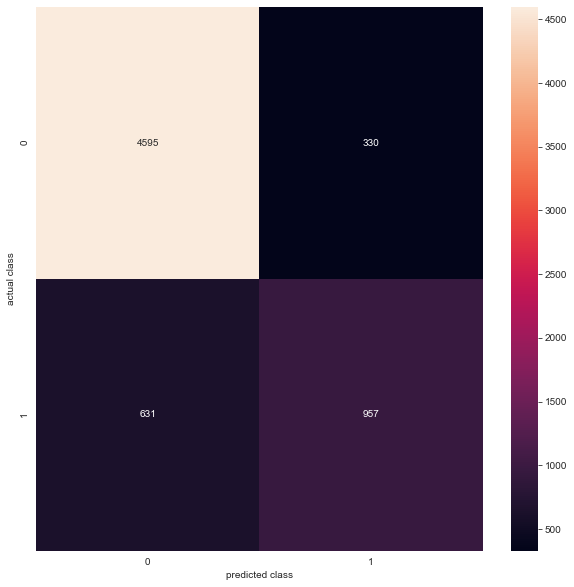

In [28]:
# Выводим матрицу ошибок
plt.figure(figsize = (10,10))
cm = confusion_matrix(y_test, predicted_lr) 
sns.heatmap(cm, annot = True,fmt = '.5g')
plt.ylabel('actual class')
plt.xlabel('predicted class')

### Строим и оцениваем модель XGBoost

In [29]:
def objective_xgb(trial):
    min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10, log=True)
    gamma = trial.suggest_float("gamma", 0.1, 10, log=True)
    subsample = trial.suggest_float("subsample", 0.1, 1, log=True)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 10, log=True)


    ## Создание модели
    classifier = xgboost.XGBClassifier(min_child_weight=min_child_weight,
                                       gamma=gamma,
                                       subsample=subsample,
                                       colsample_bytree=colsample_bytree,
                                       max_depth=max_depth,
                                       eval_metric='mlogloss'
                                   )
    ## Обучаем модель
    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

In [30]:
# Промодим оптимизацию гиперпараметров
study_xgb = optuna.create_study(study_name="XGBClassifier", direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)

[I 2022-02-06 18:10:46,389] A new study created in memory with name: XGBClassifier
[I 2022-02-06 18:10:47,981] Trial 0 finished with value: 0.8595117457392907 and parameters: {'min_child_weight': 4.0359120603267975, 'gamma': 0.11292066878787972, 'subsample': 0.492290453495883, 'colsample_bytree': 0.21383207730710874, 'max_depth': 1}. Best is trial 0 with value: 0.8595117457392907.
[I 2022-02-06 18:10:49,214] Trial 1 finished with value: 0.8707200982650084 and parameters: {'min_child_weight': 1.7922988164083389, 'gamma': 9.592769664310921, 'subsample': 0.9149949491496184, 'colsample_bytree': 0.15489453576214288, 'max_depth': 5}. Best is trial 1 with value: 0.8707200982650084.
[I 2022-02-06 18:10:50,742] Trial 2 finished with value: 0.8636573007830493 and parameters: {'min_child_weight': 0.10583381799126013, 'gamma': 2.8609773107438734, 'subsample': 0.15392674517623225, 'colsample_bytree': 0.4832873361810104, 'max_depth': 3}. Best is trial 1 with value: 0.8707200982650084.
[I 2022-02-06 

In [31]:
print("Лучшие параметры : {}".format(study_xgb.best_params))
print("Наилучшая точность : {}".format(study_xgb.best_value))

Лучшие параметры : {'min_child_weight': 5.3807804520346565, 'gamma': 0.1433340246695772, 'subsample': 0.5641465235380083, 'colsample_bytree': 0.2970963248415011, 'max_depth': 4}
Наилучшая точность : 0.8765545831414094


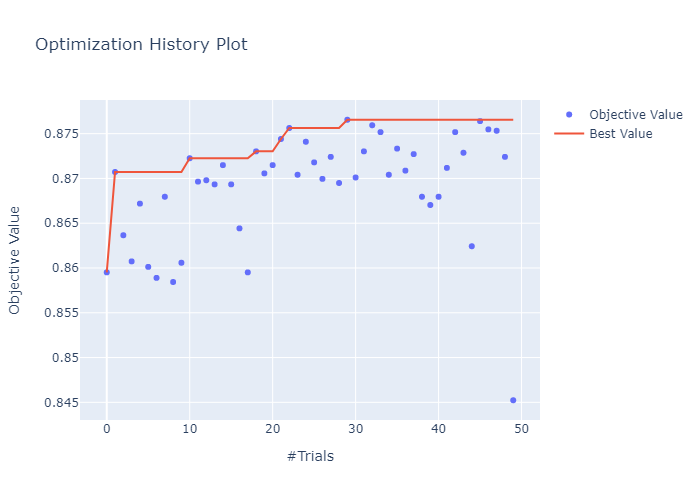

In [32]:
fig = optuna.visualization.plot_optimization_history(study_xgb)
fig.show("png")

In [33]:
xgb = xgboost.XGBClassifier(**study_xgb.best_params, multi_class="auto")
xgb.fit(X_train, y_train)
predicted_xgb = xgb.predict(X_test)

[18:12:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "multi_class" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:12:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [34]:
accuracy_xgb = accuracy_score(y_test, predicted_xgb)

# Метрики качества модели
print(classification_report(y_test, predicted_xgb))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4925
           1       0.79      0.67      0.73      1588

    accuracy                           0.88      6513
   macro avg       0.85      0.81      0.82      6513
weighted avg       0.87      0.88      0.87      6513



Text(0.5, 70.0, 'predicted class')

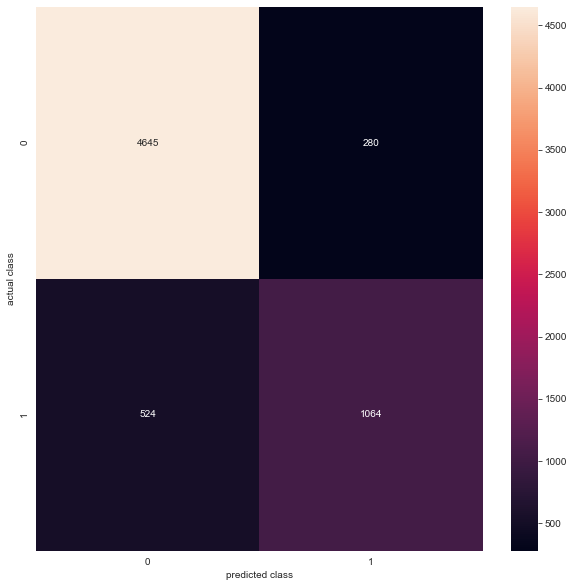

In [36]:
# Выводим матрицу ошибок
plt.figure(figsize = (10,10))
cm = confusion_matrix(y_test, predicted_xgb) 
sns.heatmap(cm, annot = True,fmt = '.5g')
plt.ylabel('actual class')
plt.xlabel('predicted class')

### Сравниваем модели между собой

In [37]:
# Создаем Дамми модель
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
predicted_dummy = dummy_clf.predict(X_test)
accuracy_dummy = accuracy_score(y_test, predicted_dummy)

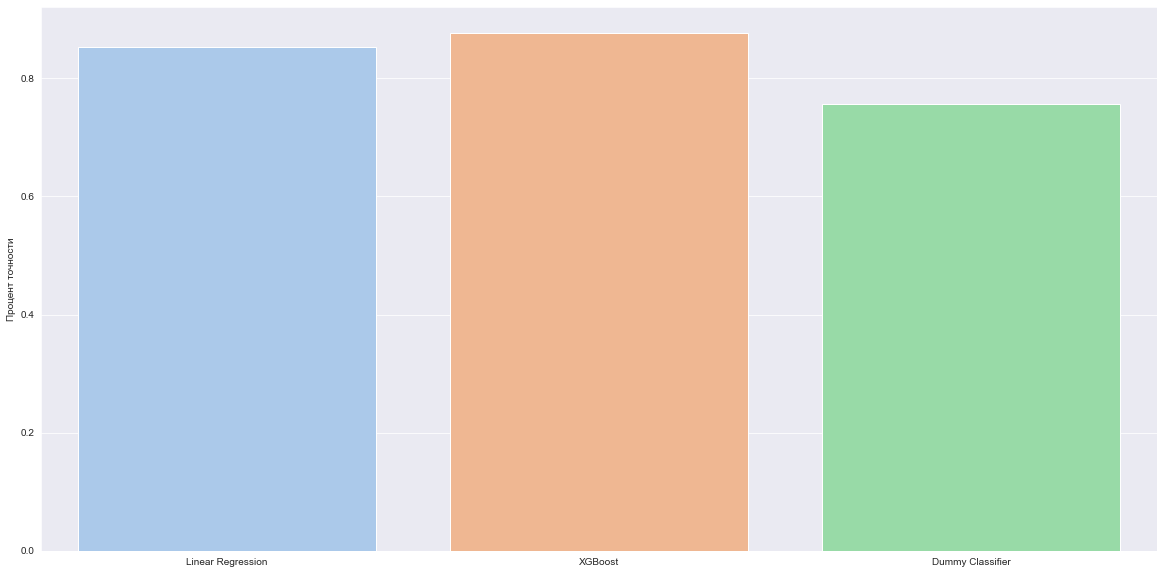

In [38]:
label = ["Linear Regression", "XGBoost", "Dummy Classifier"]
accuracy = [accuracy_lr, accuracy_xgb, accuracy_dummy]

# Выводим наглядную разницу в точностях моделей
plt.figure(figsize = (20,10))
ax = sns.barplot(y = accuracy, x = label)
ax.set_ylabel("Процент точности")
plt.show('png')